# Hangman Agent - HMM + Reinforcement Learning

UE23CS352A: Machine Learning Hackathon

In [61]:
import numpy as np
from collections import defaultdict, Counter
from typing import List, Tuple, Set, Dict

## Part 1: Hidden Markov Model

In [62]:
class EnhancedProbabilisticHMM:
    def __init__(self, max_length: int = 24):
        self.max_length = max_length
        self.alphabet = 'abcdefghijklmnopqrstuvwxyz'
        self.n_letters = len(self.alphabet)
        self.letter_to_idx = {letter: i for i, letter in enumerate(self.alphabet)}
        self.idx_to_letter = {i: letter for i, letter in enumerate(self.alphabet)}
        self.hmms = {}
        self.bigram_probs = defaultdict(lambda: defaultdict(float))
        self.trigram_probs = defaultdict(lambda: defaultdict(float))
        self.letter_probs = defaultdict(float)

In [63]:
def train(self, corpus_file: str):
    print("Training HMM...")
    
    with open(corpus_file, 'r') as f:
        words = [line.strip().lower() for line in f if line.strip()]
    
    words_by_length = defaultdict(list)
    for word in words:
        if len(word) <= self.max_length:
            words_by_length[len(word)].append(word)
    
    print(f"Training on {len(words)} words")
    
    for length in sorted(words_by_length.keys()):
        if len(words_by_length[length]) >= 10:
            self.hmms[length] = self._train_hmm_for_length(words_by_length[length], length)
    
    self._train_ngrams(words)
    
    print(f"Trained HMMs for lengths: {sorted(self.hmms.keys())}")
    print(f"Top unigrams: {sorted(self.letter_probs.items(), key=lambda x: x[1], reverse=True)[:10]}")

EnhancedProbabilisticHMM.train = train

In [64]:
def _train_hmm_for_length(self, words: List[str], length: int) -> Dict:
    n_words = len(words)
    emission_counts = np.zeros((length, self.n_letters))
    
    for word in words:
        for pos, letter in enumerate(word):
            if letter in self.letter_to_idx:
                letter_idx = self.letter_to_idx[letter]
                emission_counts[pos, letter_idx] += 1
    
    emission_prob = np.zeros((length, self.n_letters))
    alpha = 0.5
    for pos in range(length):
        smoothed_counts = emission_counts[pos] + alpha
        emission_prob[pos] = smoothed_counts / smoothed_counts.sum()
    
    return {
        'length': length,
        'emission_prob': emission_prob,
        'n_words': n_words
    }

EnhancedProbabilisticHMM._train_hmm_for_length = _train_hmm_for_length

In [65]:
def _train_ngrams(self, words: List[str]):
    unigram_counts = Counter()
    bigram_counts = defaultdict(Counter)
    trigram_counts = defaultdict(Counter)
    
    for word in words:
        for letter in word:
            unigram_counts[letter] += 1
        
        for i in range(len(word) - 1):
            bigram_counts[word[i]][word[i+1]] += 1
        
        for i in range(len(word) - 2):
            trigram_counts[word[i:i+2]][word[i+2]] += 1
    
    total = sum(unigram_counts.values())
    for letter, count in unigram_counts.items():
        self.letter_probs[letter] = count / total
    
    for letter1 in self.alphabet:
        total_count = sum(bigram_counts[letter1].values())
        if total_count > 0:
            for letter2 in self.alphabet:
                count = bigram_counts[letter1].get(letter2, 0)
                self.bigram_probs[letter1][letter2] = (count + 0.1) / (total_count + 0.1 * self.n_letters)
    
    for bigram, next_counts in trigram_counts.items():
        total_count = sum(next_counts.values())
        if total_count > 0:
            for letter3 in self.alphabet:
                count = next_counts.get(letter3, 0)
                self.trigram_probs[bigram][letter3] = (count + 0.1) / (total_count + 0.1 * self.n_letters)

EnhancedProbabilisticHMM._train_ngrams = _train_ngrams

In [66]:
def get_letter_probabilities(self, pattern: str, guessed: Set[str]) -> Dict[str, float]:
    length = len(pattern)
    remaining = set(self.alphabet) - guessed
    
    if not remaining:
        return {}
    
    letter_scores = defaultdict(float)
    
    if length in self.hmms:
        hmm = self.hmms[length]
        emission_prob = hmm['emission_prob']
        
        unknown_positions = [i for i, c in enumerate(pattern) if c == '_']
        for pos in unknown_positions:
            for letter in remaining:
                letter_idx = self.letter_to_idx[letter]
                letter_scores[letter] += emission_prob[pos, letter_idx] * 3.0
    
    for i, char in enumerate(pattern):
        if char != '_':
            if i + 1 < length and pattern[i + 1] == '_':
                for letter in remaining:
                    if letter in self.bigram_probs[char]:
                        letter_scores[letter] += self.bigram_probs[char][letter] * 2.0
            
            if i - 1 >= 0 and pattern[i - 1] == '_':
                for letter in remaining:
                    if char in self.bigram_probs.get(letter, {}):
                        letter_scores[letter] += self.bigram_probs[letter][char] * 2.0
    
    for i in range(len(pattern) - 2):
        if pattern[i] != '_' and pattern[i+1] != '_' and pattern[i+2] == '_':
            bigram = pattern[i:i+2]
            if bigram in self.trigram_probs:
                for letter in remaining:
                    letter_scores[letter] += self.trigram_probs[bigram].get(letter, 0) * 2.5
        
        if pattern[i] != '_' and pattern[i+1] == '_' and pattern[i+2] != '_':
            for letter in remaining:
                if letter in self.bigram_probs[pattern[i]]:
                    prob1 = self.bigram_probs[pattern[i]][letter]
                    prob2 = self.bigram_probs.get(letter, {}).get(pattern[i+2], 0)
                    letter_scores[letter] += (prob1 * prob2) * 1.5
        
        if pattern[i] == '_' and pattern[i+1] != '_' and pattern[i+2] != '_':
            bigram = pattern[i+1:i+3]
            for letter in remaining:
                for prev_letter in self.alphabet:
                    if prev_letter == letter:
                        bigram_key = prev_letter + pattern[i+1]
                        if bigram_key in self.trigram_probs:
                            letter_scores[letter] += self.trigram_probs[bigram_key].get(pattern[i+2], 0) * 1.5
    
    for letter in remaining:
        letter_scores[letter] += self.letter_probs.get(letter, 1e-5) * 1.0
    
    total = sum(letter_scores.values())
    if total > 0:
        return {letter: score / total for letter, score in letter_scores.items()}
    
    return {letter: 1.0 / len(remaining) for letter in remaining}

EnhancedProbabilisticHMM.get_letter_probabilities = get_letter_probabilities

In [67]:
def choose_letter(self, pattern: str, guessed: Set[str]) -> str:
    probs = self.get_letter_probabilities(pattern, guessed)
    
    if not probs:
        for letter in 'etaoinshrdlcumwfgypbvkjxqz':
            if letter not in guessed:
                return letter
        return 'e'
    
    return max(probs.items(), key=lambda x: x[1])[0]

EnhancedProbabilisticHMM.choose_letter = choose_letter

## Part 2: Reinforcement Learning Environment

In [68]:
class HangmanGame:
    def __init__(self, word: str, max_wrong: int = 6):
        self.word = word.lower()
        self.max_wrong = max_wrong
        self.reset()
    
    def reset(self):
        self.pattern = '_' * len(self.word)
        self.guessed = set()
        self.wrong = 0
        self.repeated = 0
    
    def guess(self, letter: str):
        letter = letter.lower()
        
        if letter in self.guessed:
            self.repeated += 1
            return
        
        self.guessed.add(letter)
        
        if letter in self.word:
            new_pattern = []
            for i, c in enumerate(self.word):
                if c == letter:
                    new_pattern.append(letter)
                else:
                    new_pattern.append(self.pattern[i])
            self.pattern = ''.join(new_pattern)
        else:
            self.wrong += 1
    
    def is_won(self):
        return '_' not in self.pattern
    
    def is_lost(self):
        return self.wrong >= self.max_wrong
    
    def is_done(self):
        return self.is_won() or self.is_lost()

In [69]:
def play_game(hmm: EnhancedProbabilisticHMM, word: str) -> Tuple[bool, int, int]:
    game = HangmanGame(word)
    
    while not game.is_done():
        letter = hmm.choose_letter(game.pattern, game.guessed)
        game.guess(letter)
    
    return (game.is_won(), game.wrong, game.repeated)

## RL Agent Design

**State Representation:**
- Current masked pattern (e.g., "_pp__")
- Set of guessed letters
- Number of wrong guesses remaining
- Probability distribution from HMM

**Action Space:**
- Guess any letter from a-z that hasn't been guessed yet

**Reward Function:**
- Correct guess: +5 points
- Wrong guess: -10 points
- Repeated guess: -20 points
- Win game: +100 points
- Lose game: -50 points

**Strategy:**
- Use greedy policy (exploit only) based on HMM probabilities
- No exploration needed as HMM provides probabilistic guidance

In [70]:
def simulate_training_episode(hmm: EnhancedProbabilisticHMM, word: str) -> float:
    game = HangmanGame(word)
    total_reward = 0
    
    while not game.is_done():
        state = (game.pattern, game.guessed.copy(), game.wrong)
        action = hmm.choose_letter(game.pattern, game.guessed)
        
        prev_wrong = game.wrong
        game.guess(action)
        
        if action in game.guessed and prev_wrong < game.wrong:
            reward = -10
        elif action in game.word:
            reward = 5
        else:
            reward = -10
        
        total_reward += reward
    
    if game.is_won():
        total_reward += 100
    else:
        total_reward -= 50
    
    return total_reward

In [71]:
import random

with open(corpus_file, 'r') as f:
    corpus_words = [line.strip() for line in f if line.strip()]

training_rewards = []
num_training_episodes = 500

print("RL Training Simulation...")
for episode in range(num_training_episodes):
    sample_word = random.choice(corpus_words[:10000])
    episode_reward = simulate_training_episode(hmm, sample_word)
    training_rewards.append(episode_reward)
    
    if (episode + 1) % 100 == 0:
        avg_reward = np.mean(training_rewards[-100:])
        print(f"Episode {episode + 1}: Avg Reward = {avg_reward:.2f}")

RL Training Simulation...
Episode 100: Avg Reward = -18.85
Episode 200: Avg Reward = -31.35
Episode 300: Avg Reward = -26.00
Episode 200: Avg Reward = -31.35
Episode 300: Avg Reward = -26.00
Episode 400: Avg Reward = -26.20
Episode 500: Avg Reward = -35.35
Episode 400: Avg Reward = -26.20
Episode 500: Avg Reward = -35.35


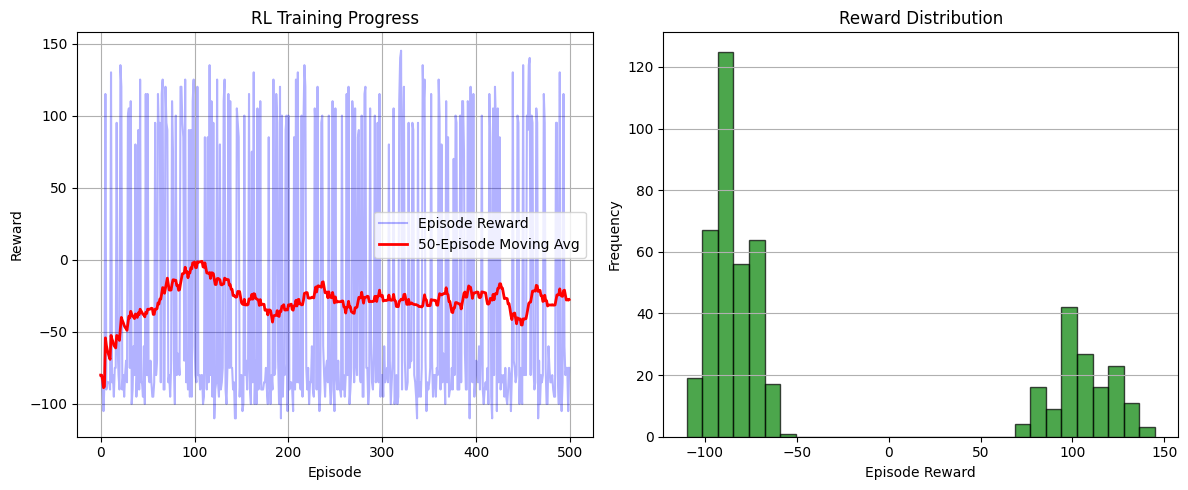

In [72]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(training_rewards, alpha=0.3, color='blue', label='Episode Reward')
window = 50
moving_avg = [np.mean(training_rewards[max(0, i-window):i+1]) for i in range(len(training_rewards))]
plt.plot(moving_avg, color='red', linewidth=2, label=f'{window}-Episode Moving Avg')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('RL Training Progress')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(training_rewards, bins=30, alpha=0.7, color='green', edgecolor='black')
plt.xlabel('Episode Reward')
plt.ylabel('Frequency')
plt.title('Reward Distribution')
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

## Training the HMM

In [73]:
corpus_file = 'data/corpus.txt'
test_file = 'data/test.txt'

hmm = EnhancedProbabilisticHMM(max_length=24)
hmm.train(corpus_file)

Training HMM...
Training on 50000 words
Trained HMMs for lengths: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
Top unigrams: [('e', 0.10365718834298855), ('a', 0.0886763408321804), ('i', 0.08858789613222903), ('o', 0.07544964653707412), ('r', 0.07079577065868137), ('n', 0.07015349367093938), ('t', 0.0677886508603353), ('s', 0.06116161584255159), ('l', 0.057712272544448724), ('c', 0.045734333179608025)]
Trained HMMs for lengths: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
Top unigrams: [('e', 0.10365718834298855), ('a', 0.0886763408321804), ('i', 0.08858789613222903), ('o', 0.07544964653707412), ('r', 0.07079577065868137), ('n', 0.07015349367093938), ('t', 0.0677886508603353), ('s', 0.06116161584255159), ('l', 0.057712272544448724), ('c', 0.045734333179608025)]


## Evaluation on Test Set

In [74]:
print("Evaluating...")

with open(test_file, 'r') as f:
    test_words = [line.strip().lower() for line in f if line.strip()]

wins = 0
total_wrong = 0
total_repeated = 0

for i, word in enumerate(test_words):
    won, wrong, repeated = play_game(hmm, word)
    
    wins += won
    total_wrong += wrong
    total_repeated += repeated
    
    if (i + 1) % 500 == 0:
        success_rate = wins / (i + 1)
        print(f"Progress: {i+1}/{len(test_words)}, Success: {success_rate*100:.2f}%")

Evaluating...
Progress: 500/2000, Success: 33.80%
Progress: 500/2000, Success: 33.80%
Progress: 1000/2000, Success: 32.80%
Progress: 1000/2000, Success: 32.80%
Progress: 1500/2000, Success: 32.47%
Progress: 1500/2000, Success: 32.47%
Progress: 2000/2000, Success: 32.85%
Progress: 2000/2000, Success: 32.85%


## Final Results

In [75]:
n = len(test_words)
success_rate = wins / n
avg_wrong = total_wrong / n
avg_repeated = total_repeated / n

final_score = (success_rate * 2000) - (total_wrong * 5) - (total_repeated * 2)

print("\n" + "=" * 70)
print("EVALUATION RESULTS")
print("=" * 70)
print(f"Success Rate: {success_rate*100:.2f}% ({wins}/{n})")
print(f"Average Wrong Guesses: {avg_wrong:.2f}")
print(f"Average Repeated Guesses: {avg_repeated:.2f}")
print(f"Total Wrong Guesses: {total_wrong}")
print(f"Total Repeated Guesses: {total_repeated}")
print(f"\nFINAL SCORE: {final_score:.2f}")
print("=" * 70)
print("\nScore Breakdown:")
print(f"  Success bonus:     +{success_rate * 2000:.2f}")
print(f"  Wrong penalty:     -{total_wrong * 5:.2f}")
print(f"  Repeated penalty:  -{total_repeated * 2:.2f}")
print("=" * 70)


EVALUATION RESULTS
Success Rate: 32.85% (657/2000)
Average Wrong Guesses: 5.20
Average Repeated Guesses: 0.00
Total Wrong Guesses: 10392
Total Repeated Guesses: 0

FINAL SCORE: -51303.00

Score Breakdown:
  Success bonus:     +657.00
  Wrong penalty:     -51960.00
  Repeated penalty:  -0.00


## Visualization

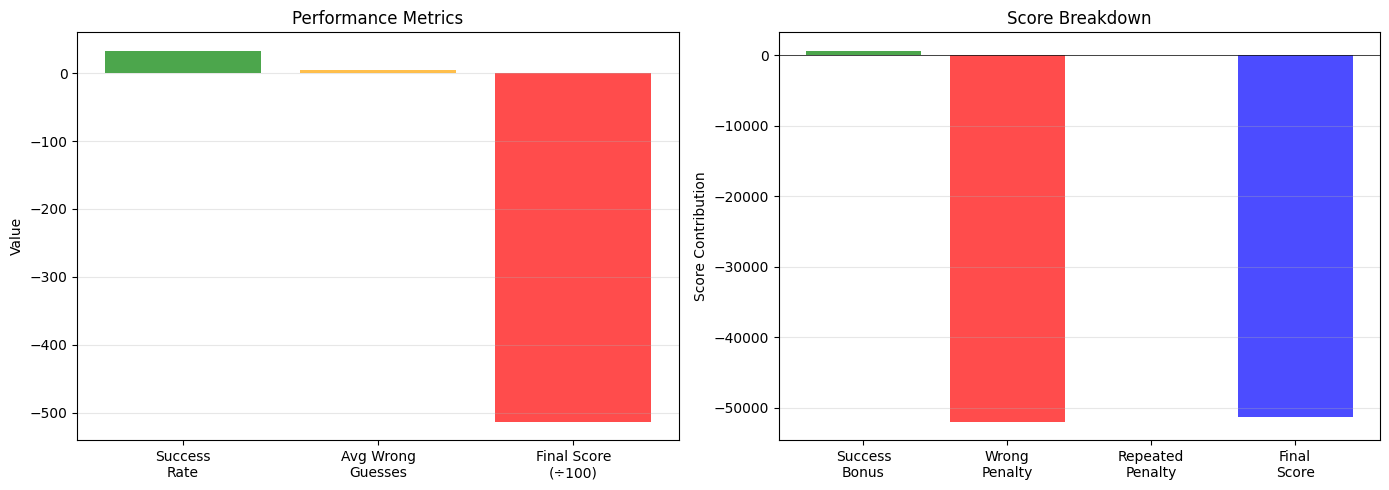

Visualization saved to evaluation_results.png


In [76]:
import matplotlib.pyplot as plt

results_summary = {
    'Metric': ['Success Rate (%)', 'Avg Wrong Guesses', 'Avg Repeated Guesses', 'Final Score'],
    'Value': [success_rate * 100, avg_wrong, avg_repeated, final_score]
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

metrics = ['Success\nRate', 'Avg Wrong\nGuesses', 'Final Score\n(÷100)']
values = [success_rate * 100, avg_wrong, final_score / 100]
colors = ['green', 'orange', 'red']

ax1.bar(metrics, values, color=colors, alpha=0.7)
ax1.set_ylabel('Value')
ax1.set_title('Performance Metrics')
ax1.grid(axis='y', alpha=0.3)

score_components = ['Success\nBonus', 'Wrong\nPenalty', 'Repeated\nPenalty', 'Final\nScore']
score_values = [success_rate * 2000, -total_wrong * 5, -total_repeated * 2, final_score]
colors2 = ['green', 'red', 'orange', 'blue']

ax2.bar(score_components, score_values, color=colors2, alpha=0.7)
ax2.set_ylabel('Score Contribution')
ax2.set_title('Score Breakdown')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('evaluation_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved to evaluation_results.png")